In [42]:
### Set up directory
import sys
import os
parent_dir = os.path.dirname(os.getcwd())
sys.path.append(parent_dir)

# Check if directory exists, if not create it
save_path = os.path.join(parent_dir, 'generated_series')
if not os.path.exists(save_path):
    os.makedirs(save_path)
    
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import os
from data.serialize import serialize_arr, deserialize_str, SerializerSettings
import pickle


def serialize_gaussian(prec, time_series, mean_series, sigma_series):
    """
    Serialize a time series with gaussian noise and continuous support.

    Parameters:
    prec (int): Precision of the serialization
    time_series (list): The time series data
    mean_series (list): The mean series data
    sigma_series (list): The sigma series data

    Returns:
    tuple: A tuple containing 
        serialized time series: str
        rescaled mean series: np array
        rescaled sigma series: np array
    """
    settings=SerializerSettings(base=10, prec=prec, signed=True, time_sep=',', bit_sep='', minus_sign='-', fixed_length=False, max_val = 10)
    time_series = np.array(time_series)
    ### Final range is from 0.15 to 0.85
    rescale_factor = 0.7
    up_shift = 0.15

    rescaled_array = (time_series-time_series.min())/(time_series.max()-time_series.min()) * rescale_factor + up_shift
    rescaled_true_mean_arr = (np.array(mean_series)-time_series.min())/(time_series.max()-time_series.min()) * rescale_factor + up_shift
    rescaled_true_sigma_arr = np.array(sigma_series)/(time_series.max()-time_series.min()) * rescale_factor 
    rescaled_true_mean_arr *= 10
    rescaled_true_sigma_arr *= 10
    full_series = serialize_arr(rescaled_array, settings)
    return (full_series, rescaled_true_mean_arr, rescaled_true_sigma_arr)


In [43]:
####################################
### Generate continuous time series
####################################

### Brownian Motion
# hyper-parameter to load from json
num_series = 5
Nt = 1000 # number of steps
a = 0 # drift
prec = 2
llama_size = '13b'
mode = 'neighbor'
refine_depth = 1
traj_name = 'brownian_motion'

# other hyper-parameters
dt =  0.2 # time step
tspan = np.linspace(0, Nt*dt, Nt)
sigma = 0.8

for traj_idx in range(num_series):
    np.random.seed(5+traj_idx)
    # Initialize the time series
    x = 0  # Starting point
    time_series = [x]
    mean_series = [x]
    sigma_series = [0]

    # Generate the drift-diffusion time series
    for t in range(1, Nt):
        x_mean = x + a*dt
        x_sigma = sigma * np.sqrt(dt)
        dW =  np.random.normal()  # Wiener process (Brownian motion)
        x = x_mean + x_sigma * dW
        
        time_series.append(x)
        mean_series.append(x_mean)
        sigma_series.append(x_sigma)
        
    # plt.figure(figsize=(10, 5))
    # plt.plot(time_series, alpha = 1)

    full_series, rescaled_true_mean_arr, rescaled_true_sigma_arr = serialize_gaussian(prec, time_series, mean_series, sigma_series)
    # Save the generated data to a dictionary
    data_dict = {
        'full_series': full_series,
        'rescaled_true_mean_arr': rescaled_true_mean_arr,
        'rescaled_true_sigma_arr': rescaled_true_sigma_arr,
        'prec': prec,
        'llama_size': llama_size,
        'mode': mode,
        'refine_depth': refine_depth
    }

    # Pickle and save the dictionary
    # Count existing files in the save_path and assign a new number
    num_files = len([name for name in os.listdir(save_path) if os.path.isfile(os.path.join(save_path, name)) and name.startswith(traj_name)])
    save_name = os.path.join(save_path, f'{traj_name}_{num_files}.pkl')
    with open(save_name, 'wb') as f:
        pickle.dump(data_dict, f)


In [44]:
### Gemetric Brownian Motion
traj_name = 'geometric_brownian_motion'
# hyper-parameter to load from json
llama_size = '13b'
refine_depth = 1
mode = 'neighbor'
prec = 2

num_series = 5
Nt = 1000 # number of steps
sigma = 0.6
a = None

if a is None:
    a = sigma**2/2
    
dt =  0.2 # time step
tspan = np.linspace(1, Nt*dt, Nt)

for traj_idx in range(num_series):
    np.random.seed(traj_idx)

    # Initialize the time series
    x = 10  # Starting point
    time_series = [x]
    mean_series = [x]
    sigma_series = [0]

    # Generate the drift-diffusion time series
    for t in range(1, Nt):
        x_mean = x + a*dt
        x_sigma = x * sigma * np.sqrt(dt)
        dW =  np.random.normal()  # Wiener process (Brownian motion)
        x = x_mean + x_sigma * dW
        
        time_series.append(x)
        mean_series.append(x_mean)
        sigma_series.append(x_sigma)
        
    # plt.figure(figsize=(10, 5))
    # plt.plot(time_series, alpha = 1)
    # plt.yscale('log')
    full_series, rescaled_true_mean_arr, rescaled_true_sigma_arr = serialize_gaussian(prec, time_series, mean_series, sigma_series)
        # Save the generated data to a dictionary
    data_dict = {
            'full_series': full_series,
            'rescaled_true_mean_arr': rescaled_true_mean_arr,
            'rescaled_true_sigma_arr': rescaled_true_sigma_arr,
            'prec': prec,
            'llama_size': llama_size,
            'mode': mode,
            'refine_depth': refine_depth
        }

    # Pickle and save the dictionary
    num_files = len([name for name in os.listdir(save_path) if os.path.isfile(os.path.join(save_path, name)) and name.startswith(traj_name)])
    save_name = os.path.join(save_path, f'{traj_name}_{num_files}.pkl')
    with open(save_name, 'wb') as f:
        pickle.dump(data_dict, f)



good seed: 3


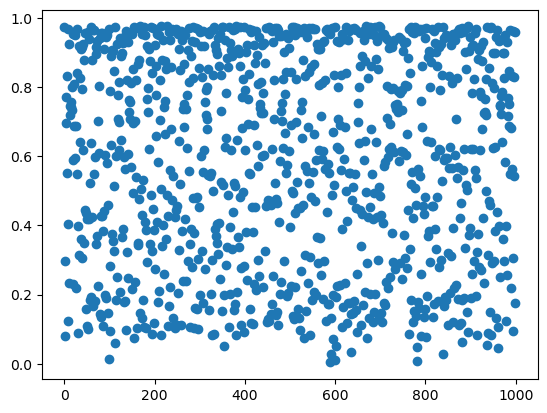

good seed: 4


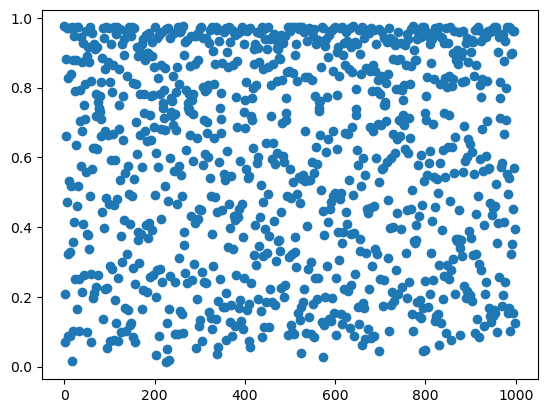

good seed: 6


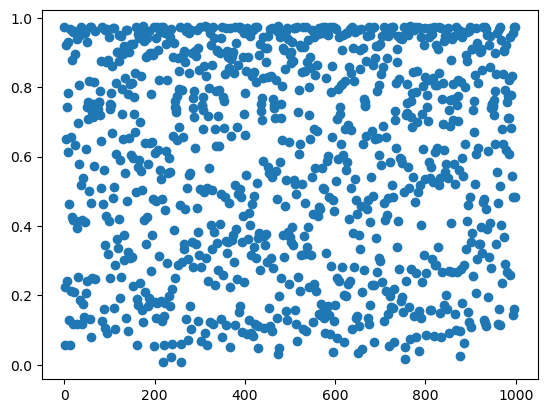

good seed: 12


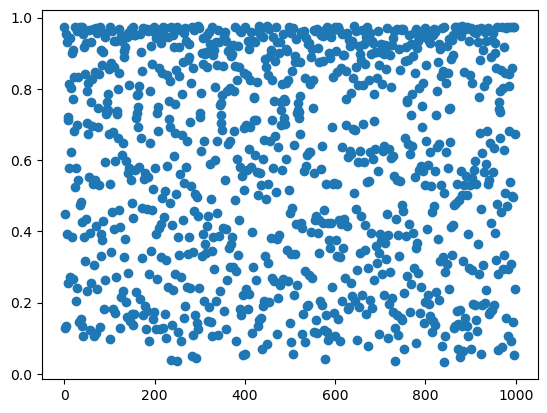

good seed: 21


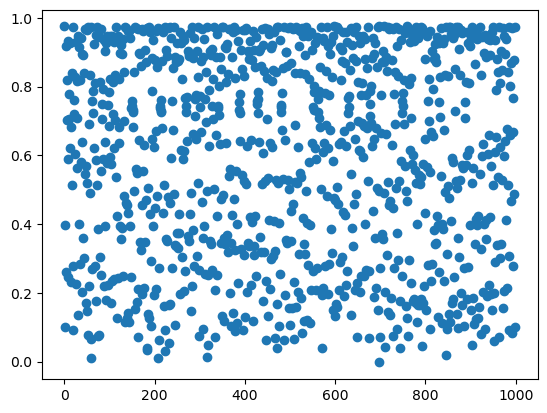

In [45]:
### Noisy Logistic Map
traj_name = 'noisy_logistic_map'
# hyper-parameter to load from json

llama_size = '13b'
mode = 'neighbor'
refine_depth = 1
prec = 2

num_series = 5
Nt = 1000
sigma = 0.0136
r = 3.9

### Logistic Map
def logistic_map(r, x):
    return r * x * (1 - x)

### Manual differentiation
def logistic_map_diff(r, x):
    return np.abs(r * (1-2*x))

counter = -1
traj_idx = 0
while counter < num_series-1:
    np.random.seed(traj_idx)
    traj_idx += 1
    x = 0.5 
    x_diff = 0 # Initial uncertainty is zero
    time_series = []
    mean_series = []
    sigma_series = []
        
    for i in range(Nt):
        x_mean = logistic_map(r, x)
        x_sigma = x_diff * sigma
        x = logistic_map(r, x + sigma * np.random.normal())
        x_diff = logistic_map_diff(r, x)
        
        time_series.append(x)
        mean_series.append(x_mean)
        sigma_series.append(x_sigma)
    
    if np.any(np.abs(np.array(time_series))>1):
        # discard stray trajectories
        continue
    else:
        print(f"good seed: {traj_idx-1}")
        counter += 1
        
    plt.plot(time_series, alpha = 1, lw = 0, marker = 'o')
    plt.show()
    full_series, rescaled_true_mean_arr, rescaled_true_sigma_arr = serialize_gaussian(prec, time_series, mean_series, sigma_series)
    # Save the generated data to a dictionary
    data_dict = {
            'full_series': full_series,
            'rescaled_true_mean_arr': rescaled_true_mean_arr,
            'rescaled_true_sigma_arr': rescaled_true_sigma_arr,
            'prec': prec,
            'llama_size': llama_size,
            'mode': mode,
            'refine_depth': refine_depth
        }
    
    # Pickle and save the dictionary
    num_files = len([name for name in os.listdir(save_path) if os.path.isfile(os.path.join(save_path, name)) and name.startswith(traj_name)])
    save_name = os.path.join(save_path, f'{traj_name}_{num_files}.pkl')
    with open(save_name, 'wb') as f:
        pickle.dump(data_dict, f)

In [46]:
### Uncorrelated Gaussian
traj_name = 'uncorrelated_gaussian'
# hyper-parameter to load from json
prec = 2
num_series = 5
refine_depth = 1
Nt = 1000 


sigma = 1
for traj_idx in range(num_series):
    np.random.seed(traj_idx)
    time_series = []
    mean_series = []
    sigma_series = []
    for t in range(0, Nt):
        W =  np.random.normal() * sigma 
        
        time_series.append(W)
        mean_series.append(0)
        sigma_series.append(sigma)
        
    # plt.figure(figsize=(10, 5))
    # plt.plot(time_series, lw = 0, marker = 'o', alpha = 1)
    
    full_series, rescaled_true_mean_arr, rescaled_true_sigma_arr = serialize_gaussian(prec, time_series, mean_series, sigma_series)
    # Save the generated data to a dictionary
    data_dict = {
            'full_series': full_series,
            'rescaled_true_mean_arr': rescaled_true_mean_arr,
            'rescaled_true_sigma_arr': rescaled_true_sigma_arr,
            'prec': prec,
            'llama_size': llama_size,
            'mode': mode,
            'refine_depth': refine_depth
        }
    
    # Pickle and save the dictionary
    num_files = len([name for name in os.listdir(save_path) if os.path.isfile(os.path.join(save_path, name)) and name.startswith(traj_name)])
    save_name = os.path.join(save_path, f'{traj_name}_{num_files}.pkl')
    with open(save_name, 'wb') as f:
        pickle.dump(data_dict, f)

In [47]:
### Uncorrelated Uniform
traj_name  = 'uncorrelated_uniform'
# hyper-parameter to load from json
llama_size = '13b'
mode = 'neighbor'
refine_depth = 1
prec = 2

num_series = 5
Nt = 1000 


sigma = 1
for traj_idx in range(num_series):
    np.random.seed(traj_idx)
    time_series = []
    mean_series = []
    sigma_series = []
    for t in range(0, Nt):
        W =  np.random.uniform() * sigma 
        
        time_series.append(W)
        # mean_series.append(0)
        # sigma_series.append(sigma)
        
    # plt.figure(figsize=(10, 5))
    # plt.plot(time_series, lw = 0, marker = 'o', alpha = 1)
    
    full_series, rescaled_true_mean_arr, rescaled_true_sigma_arr = serialize_gaussian(prec, time_series, mean_series, sigma_series)
    # Save the generated data to a dictionary
    data_dict = {
            'full_series': full_series,
            # 'rescaled_true_mean_arr': rescaled_true_mean_arr,
            # 'rescaled_true_sigma_arr': rescaled_true_sigma_arr,
            'prec': prec,
            'llama_size': llama_size,
            'mode': mode,
            'refine_depth': refine_depth
        }
    
    # Pickle and save the dictionary
    num_files = len([name for name in os.listdir(save_path) if os.path.isfile(os.path.join(save_path, name)) and name.startswith(traj_name)])
    save_name = os.path.join(save_path, f'{traj_name}_{num_files}.pkl')
    with open(save_name, 'wb') as f:
        pickle.dump(data_dict, f)